In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib_venn import venn3, venn2
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

# log(y) = mx + b
# y = 10^(mx + b) = 10^b * 10^(mx)
def line_of_best_fit(x, fit):
    m, b = fit
    return 10**b * 10**(m * x)

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

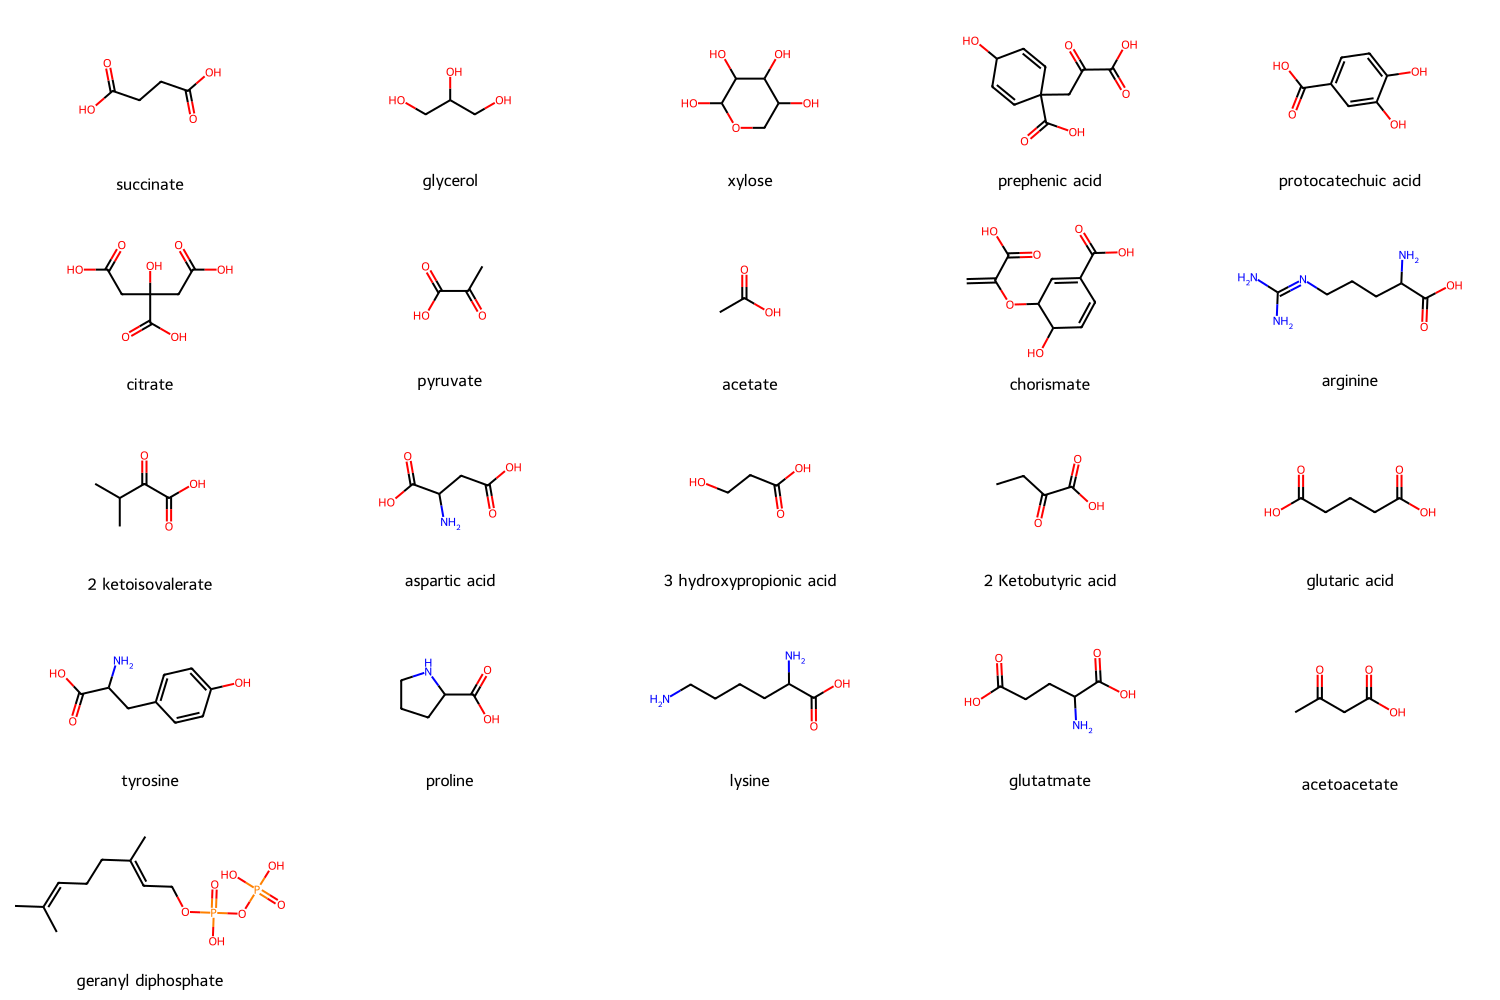

In [2]:
starters_name = "250728_benchmark_starters"

starters = pd.read_csv(Path(cfg.artifacts) / "starters" / f"{starters_name}.csv")
MolsToGridImage(mols=[Chem.MolFromSmiles(s) for s in starters.smiles], molsPerRow=5, subImgSize=(300,200), legends=[name.replace("_"," ") for name in starters.id])

In [3]:
expansion_name = f"2_steps_{starters_name}"
a_plus_b = True
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*compound_metrics.parquet"):
    df = pd.read_parquet(p)
    dfes.append(df)

cpd_df = pd.concat(dfes, ignore_index=True)
cpd_df['expansion'] = cpd_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head()

expansion gen      fan_out  \
                                                                 mean   
0  2_steps_250728_benchmark_starters_rules_imt_ru...   0  4441.238095   
1  2_steps_250728_benchmark_starters_rules_imt_ru...   1   770.442600   
2  2_steps_250728_benchmark_starters_rules_mechin...   0   113.000000   
3  2_steps_250728_benchmark_starters_rules_mechin...   1    36.695733   
4  2_steps_250728_benchmark_starters_rules_mechin...   0   164.761905   

                
           std  
0  8316.820065  
1   608.862718  
2    66.388252  
3    25.166734  
4   158.383050

In [4]:
known_reactions = {}

for exp_name in cpd_df["expansion"].unique():
    rule_set = exp_name.split("_rules_")[1]
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[exp_name] = rxns
    del mapped_rxns

/home/stef/cgr/data/raw/mapped_known_reactions_x_imt_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_01_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_02_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_04_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_13_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_91_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_0_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_2_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_3_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_4_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rdchiral_rules.parquet


In [5]:
ds = 10
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*reaction_metrics.parquet"):
    if "batch" in str(p):
        print(p)
        if int(str(p).split("_")[1]) % ds != 0:
            continue
    
    df = pd.read_parquet(p)
    dfes.append(df)

rxn_df = pd.concat(dfes, ignore_index=True)
del dfes, df
rxn_df['expansion'] = rxn_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["expansion"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
rxn_df = rxn_df.explode("rules")
rxn_df['rules'] = rxn_df['rules'].apply(lambda x : x.split('_')[0])
rxn_df['rules'] = rxn_df.apply(lambda row : f"{row['expansion'].split('_rules_')[1]}_rule_{row['rules']}", axis=1)
print(len(rxn_df))
rxn_df.head()

/home/stef/cgr/data/processed/batch_19_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_2_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_6_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_16_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_0_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_1_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_14_of_20_2_steps_250728_benchmark_star

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,Rb342395840e1257a62162ead2eb6a55efd37b3b357dce...,O=C(O)CCC(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.836046,*OC(=O)C(*)=O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O...,4d2ae57e3f60161b4a667507efb6dd62c7ca211f,mechinferred_dt_13_rule_7,2_steps_250728_benchmark_starters_rules_mechin...,False
1,R3b13c2140a2fdc645a4458e189703590a28c7dbe77f09...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,0,0.727607,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,40d495b06562cc98f426f0a38a7ecd42c34ee640,mechinferred_dt_13_rule_11,2_steps_250728_benchmark_starters_rules_mechin...,False
1,R3b13c2140a2fdc645a4458e189703590a28c7dbe77f09...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,0,0.727607,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,40d495b06562cc98f426f0a38a7ecd42c34ee640,mechinferred_dt_13_rule_11,2_steps_250728_benchmark_starters_rules_mechin...,False
1,R3b13c2140a2fdc645a4458e189703590a28c7dbe77f09...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,0,0.727607,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,40d495b06562cc98f426f0a38a7ecd42c34ee640,mechinferred_dt_13_rule_2882,2_steps_250728_benchmark_starters_rules_mechin...,False
1,R3b13c2140a2fdc645a4458e189703590a28c7dbe77f09...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,0,0.727607,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,40d495b06562cc98f426f0a38a7ecd42c34ee640,mechinferred_dt_13_rule_35,2_steps_250728_benchmark_starters_rules_mechin...,False


In [6]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean"], "max_rxn_sim": ["mean", "std"]}).head(15)

dxgb_label max_rxn_sim  \
                                                         mean        mean   
expansion                                                                   
2_steps_250728_benchmark_starters_rules_imt_rul...   0.042570    0.402396   
2_steps_250728_benchmark_starters_rules_mechinf...   0.445961    0.792033   
2_steps_250728_benchmark_starters_rules_mechinf...   0.429044    0.776306   
2_steps_250728_benchmark_starters_rules_mechinf...   0.379020    0.759460   
2_steps_250728_benchmark_starters_rules_mechinf...   0.338966    0.721032   
2_steps_250728_benchmark_starters_rules_mechinf...   0.252158    0.647853   
2_steps_250728_benchmark_starters_rules_mechinf...   0.287426    0.750420   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.048629    0.337999   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.385068    0.822913   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.458391    0.873377   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.426931    0.871995   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.406355    0.855157   
2_steps_250728_benchmark_starters_rules_rdchira...   0.364989    0.738122   

                                                              
                                                         std  
expansion                                                     
2_steps_250728_benchmark_starters_rules_imt_rul...  0.253009  
2_steps_250728_benchmark_starters_rules_mechinf...  0.154865  
2_steps_250728_benchmark_starters_rules_mechinf...  0.161857  
2_steps_250728_benchmark_starters_rules_mechinf...  0.184608  
2_steps_250728_benchmark_starters_rules_mechinf...  0.197987  
2_steps_250728_benchmark_starters_rules_mechinf...  0.223540  
2_steps_250728_benchmark_starters_rules_mechinf...  0.175488  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.236167  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.124262  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.093219  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.099698  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.102566  
2_steps_250728_benchmark_starters_rules_rdchira...  0.192842

In [34]:
tmp = rxn_df.groupby("rules").agg({"dxgb_label": ["mean"], "max_rxn_sim": ["mean", "std"], "expansion":"first"}).reset_index()
tmp.columns = ['_'.join([str(x) for x in col]).strip('_') if isinstance(col, tuple) else str(col) for col in tmp.columns]
ave_by_rule = tmp.groupby("expansion_first").agg({"dxgb_label_mean": ["mean", "std"], "max_rxn_sim_mean": ["mean", "std"]}).reset_index()
ave_by_rule.columns = ['expansion', 'dxgb_frac', 'dxgb_std', 'max_rxn_sim_mean', 'max_rxn_sim_std']
ave_by_rule.head(15)

,expansion,dxgb_frac,dxgb_std,max_rxn_sim_mean,max_rxn_sim_std
0,2_steps_250728_benchmark_starters_rules_imt_ru...,0.285120,0.356190,0.627189,0.238288
1,2_steps_250728_benchmark_starters_rules_mechin...,0.585009,0.447164,0.832309,0.152493
2,2_steps_250728_benchmark_starters_rules_mechin...,0.535436,0.444545,0.796082,0.162013
3,2_steps_250728_benchmark_starters_rules_mechin...,0.492802,0.433362,0.768101,0.177034
4,2_steps_250728_benchmark_starters_rules_mechin...,0.461700,0.415496,0.712952,0.185695
5,2_steps_250728_benchmark_starters_rules_mechin...,0.364023,0.364421,0.594662,0.199087
6,2_steps_250728_benchmark_starters_rules_mechin...,0.442020,0.393894,0.703308,0.165405
7,2_steps_250728_benchmark_starters_rules_rc_plu...,0.151322,0.230134,0.429836,0.235119
8,2_steps_250728_benchmark_starters_rules_rc_plu...,0.494893,0.440881,0.782024,0.133023
9,2_steps_250728_benchmark_starters_rules_rc_plu...,0.578533,0.454723,0.892075,0.092703


In [8]:
ct_df = rxn_df.groupby("expansion").size().reset_index(name="n_rxns")
unscl = ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'].values[0]
ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'] = unscl * ds
ct_df.head(13)

,expansion,n_rxns
0,2_steps_250728_benchmark_starters_rules_imt_ru...,2536191
1,2_steps_250728_benchmark_starters_rules_mechin...,28581
2,2_steps_250728_benchmark_starters_rules_mechin...,46226
3,2_steps_250728_benchmark_starters_rules_mechin...,95293
4,2_steps_250728_benchmark_starters_rules_mechin...,160267
5,2_steps_250728_benchmark_starters_rules_mechin...,312518
6,2_steps_250728_benchmark_starters_rules_mechin...,74513
7,2_steps_250728_benchmark_starters_rules_rc_plu...,15062750
8,2_steps_250728_benchmark_starters_rules_rc_plu...,53549
9,2_steps_250728_benchmark_starters_rules_rc_plu...,18746


In [9]:
template_sizes = pd.read_csv(
    Path(cfg.processed_data) / "template_size_stats.csv"
)
template_sizes.head(10)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_91_rules,3,3.0,5.0,5.832289,8.0,17
1,mechinferred_dt_13_rules,3,6.0,10.0,10.805556,15.0,40
2,mechinferred_dt_04_rules,3,9.0,14.0,16.901662,20.0,137
3,mechinferred_dt_02_rules,3,13.0,25.0,27.505676,36.0,178
4,mechinferred_dt_01_rules,3,16.0,29.0,30.725779,39.0,187
5,rc_plus_0_rules,3,4.0,6.0,6.695736,9.0,15
6,rc_plus_1_rules,3,6.0,8.0,8.889249,12.0,31
7,rc_plus_2_rules,3,10.0,12.0,13.415592,17.0,35
8,rc_plus_3_rules,3,12.0,16.0,17.150463,22.0,44
9,rc_plus_4_rules,3,14.0,21.0,20.757402,27.0,51


In [10]:
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.91",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.13",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.04",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.02",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.01",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': "Pathway-level clustering",
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': "RDChiral",
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("darkorange"),
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("blue"),
}

exp_names = list(exp_labels.keys())

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

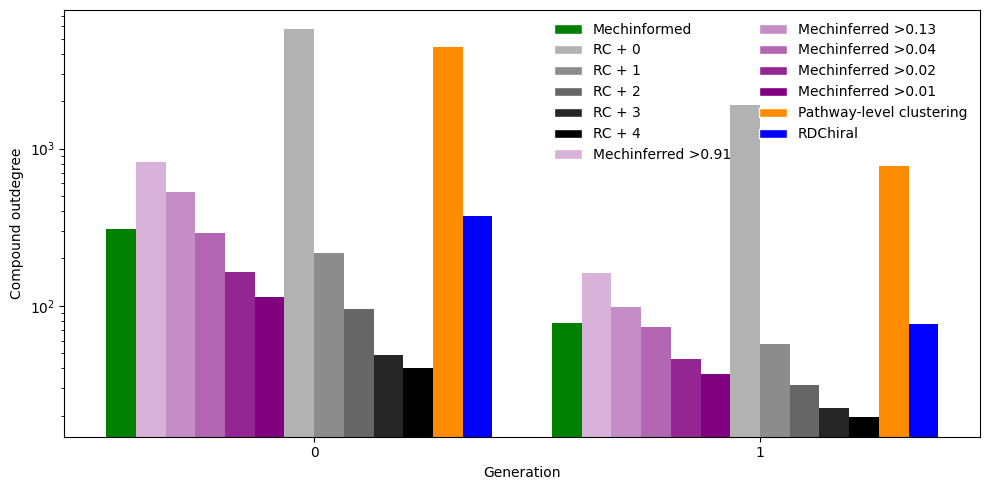

In [11]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))
ax.set_yscale('log')
ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_fan_out_clustered_bar_graph.svg", format="svg")
plt.show()
        

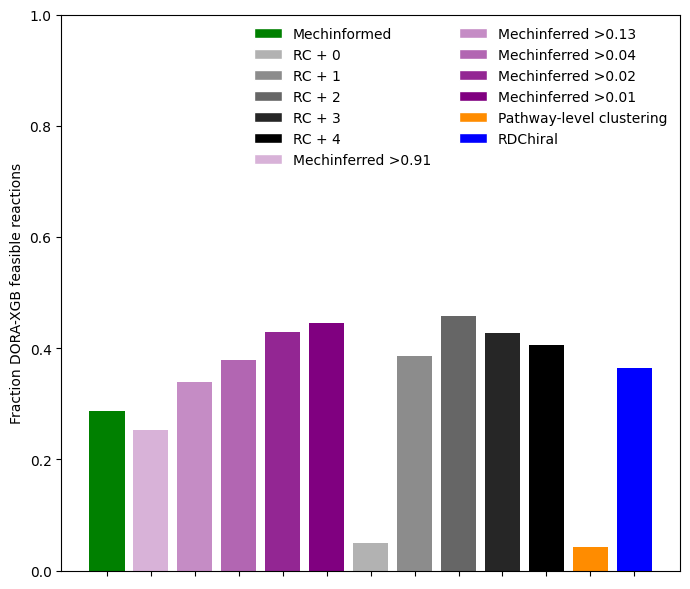

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_feasibility_bar_graph.svg", format="svg")
plt.show()

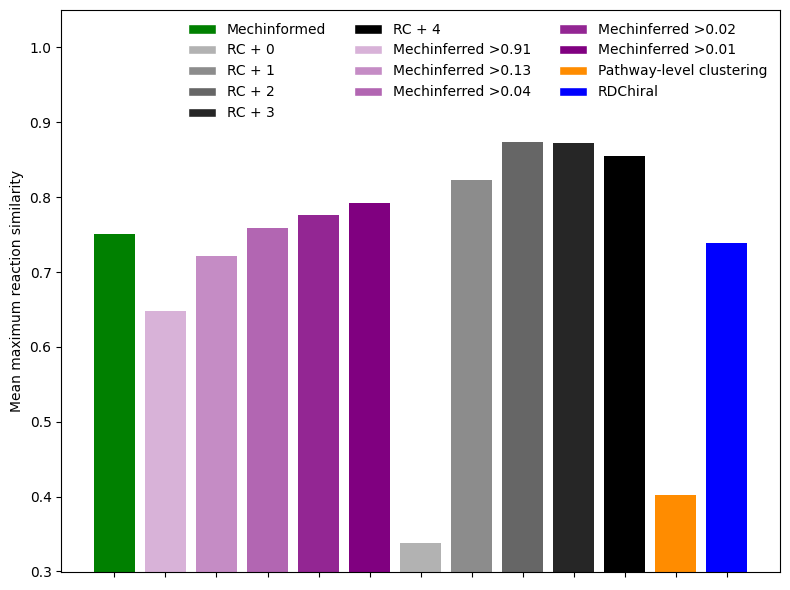

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_bar_graph.svg", format="svg")
plt.show()

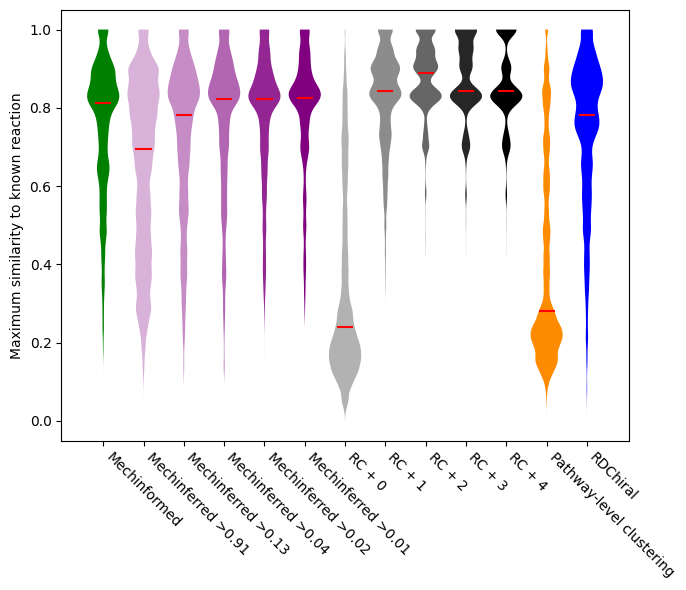

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_violin_plot.svg", format="svg")
plt.show()

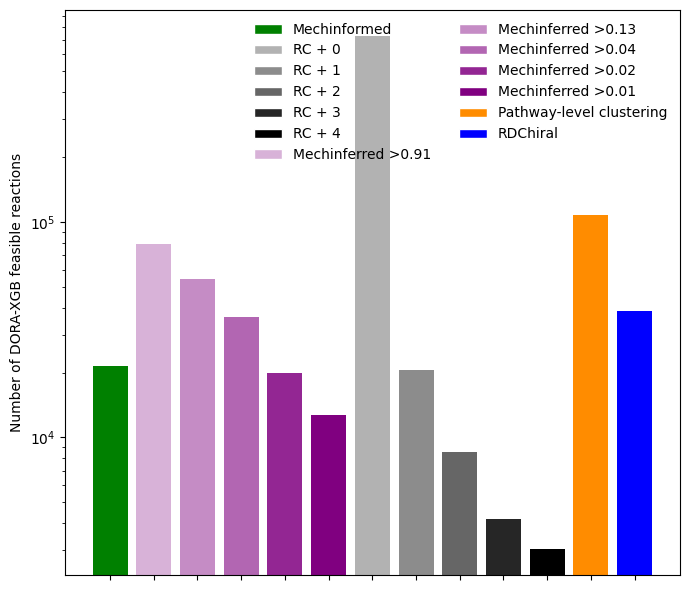

In [15]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

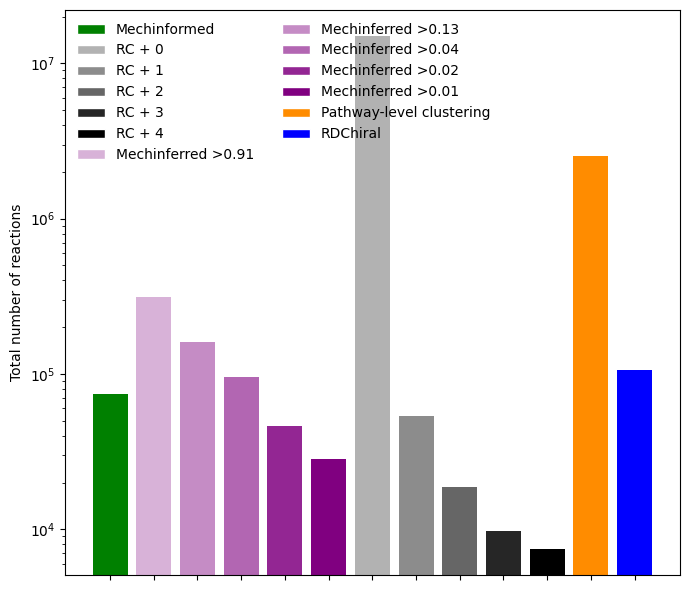

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_bar_graph.svg", format="svg")
plt.show()

In [ ]:
mechinferred_points = []
rcplus_points = []
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    
    if "mechinferred" in exp_name:
        mechinferred_points.append((feas_frac, tot_rxns))

    if "rc_plus" in exp_name:
        rcplus_points.append((feas_frac, tot_rxns))

# Fit lines to the points
mechinferred_points = np.array(mechinferred_points)
rcplus_points = np.array(rcplus_points)

mechinferred_fit = np.polyfit(mechinferred_points[:, 0], np.log10(mechinferred_points[:, 1]), 1)
rcplus_fit = np.polyfit(rcplus_points[:, 0], np.log10(rcplus_points[:, 1]), 1)
print("Mechinferred fit:", mechinferred_fit)
print("RC+ fit:", rcplus_fit)

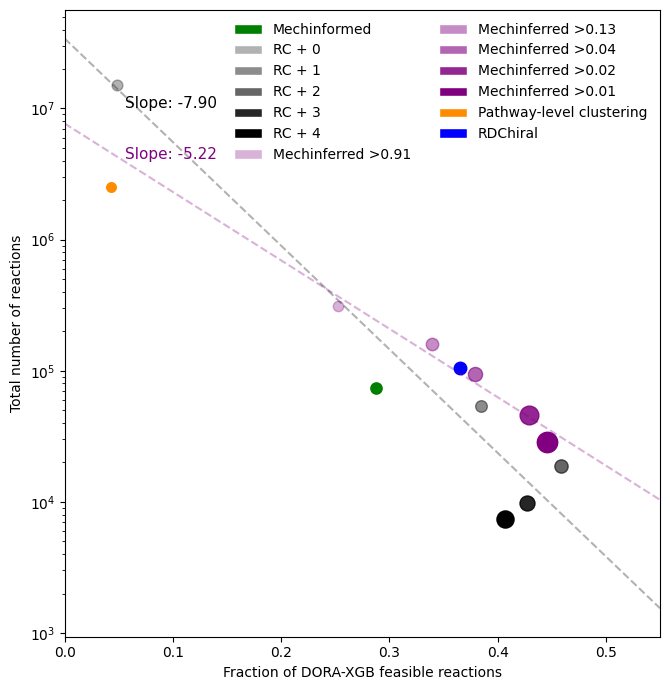

In [28]:
fig, ax = plt.subplots(figsize=(6.8, 7))
width = 0.8
xmin = 0
xmax = 0.55
dot_slope = 0.3
dot_intercept = 6

for exp_name in exp_names:
    abbrev = f"{exp_name.split("_rules_")[1]}_rules"
    template_size = template_sizes.loc[template_sizes["name"] == abbrev, "median"].values[0]
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color, markersize=dot_intercept + dot_slope * template_size)

    if feas_frac < xmin:
        xmin = feas_frac
    if feas_frac > xmax:
        xmax = feas_frac

xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, line_of_best_fit(xrange, mechinferred_fit), color=matplotlib.colors.to_rgba("purple", alpha=0.3), linestyle="--", label="Mechinferred fit")
ax.plot(xrange, line_of_best_fit(xrange, rcplus_fit), color=matplotlib.colors.to_rgba("black", alpha=0.3), linestyle="--", label="RC + n fit")

# Add slope labels to the fitted lines
mechinferred_slope = mechinferred_fit[0]
rcplus_slope = rcplus_fit[0]
label_idx = 10

ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], mechinferred_fit),
    f"Slope: {mechinferred_slope:.2f}", color=matplotlib.colors.to_rgba("purple", alpha=1.0),
    va='bottom', ha='left', fontsize=11
)
ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], rcplus_fit),
    f"Slope: {rcplus_slope:.2f}", color=matplotlib.colors.to_rgba("black", alpha=1.0),
    va='top', ha='left', fontsize=11
)
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
ax.set_xlim(xmin, xmax)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_feasibility.svg", format="svg")
plt.show()

In [44]:
mechinferred_points = []
rcplus_points = []
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = ave_by_rule.loc[ave_by_rule["expansion"] == exp_name, 'dxgb_frac'].values[0]
    
    if "mechinferred" in exp_name:
        mechinferred_points.append((feas_frac, tot_rxns))

    if "rc_plus" in exp_name:
        rcplus_points.append((feas_frac, tot_rxns))

# Fit lines to the points
mechinferred_points = np.array(mechinferred_points)
rcplus_points = np.array(rcplus_points)

mechinferred_fit = np.polyfit(mechinferred_points[:, 0], np.log10(mechinferred_points[:, 1]), 1)
rcplus_fit = np.polyfit(rcplus_points[:, 0], np.log10(rcplus_points[:, 1]), 1)
print("Mechinferred fit:", mechinferred_fit)
print("RC+ fit:", rcplus_fit)

Mechinferred fit: [-4.88522133  7.34293047]
RC+ fit: [-6.9871391   8.22933675]


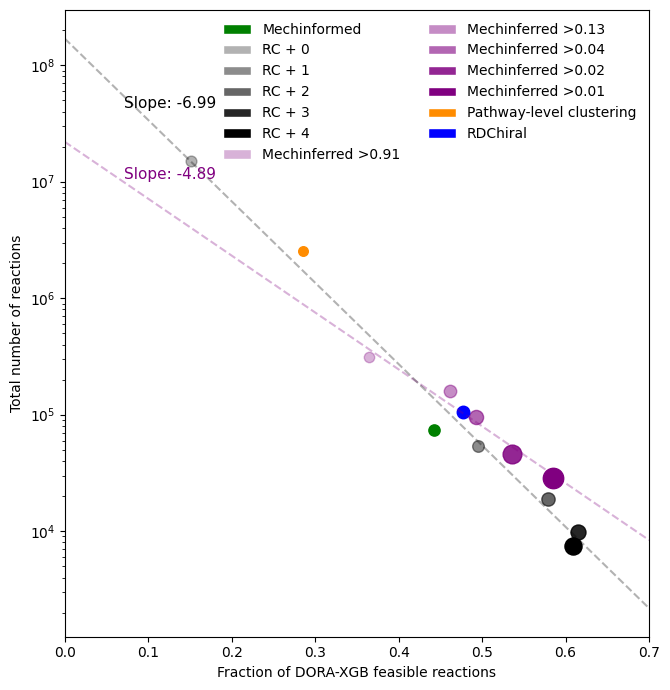

In [46]:
fig, ax = plt.subplots(figsize=(6.8, 7))
width = 0.8
xmin = 0
xmax = 0.7
dot_slope = 0.3
dot_intercept = 6

for exp_name in exp_names:
    abbrev = f"{exp_name.split("_rules_")[1]}_rules"
    template_size = template_sizes.loc[template_sizes["name"] == abbrev, "median"].values[0]
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = ave_by_rule.loc[ave_by_rule["expansion"] == exp_name, 'dxgb_frac'].values[0]
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color, markersize=dot_intercept + dot_slope * template_size)

    if feas_frac < xmin:
        xmin = feas_frac
    if feas_frac > xmax:
        xmax = feas_frac

xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, line_of_best_fit(xrange, mechinferred_fit), color=matplotlib.colors.to_rgba("purple", alpha=0.3), linestyle="--", label="Mechinferred fit")
ax.plot(xrange, line_of_best_fit(xrange, rcplus_fit), color=matplotlib.colors.to_rgba("black", alpha=0.3), linestyle="--", label="RC + n fit")

# Add slope labels to the fitted lines
mechinferred_slope = mechinferred_fit[0]
rcplus_slope = rcplus_fit[0]
label_idx = 10

ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], mechinferred_fit),
    f"Slope: {mechinferred_slope:.2f}", color=matplotlib.colors.to_rgba("purple", alpha=1.0),
    va='bottom', ha='left', fontsize=11
)
ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], rcplus_fit),
    f"Slope: {rcplus_slope:.2f}", color=matplotlib.colors.to_rgba("black", alpha=1.0),
    va='top', ha='left', fontsize=11
)
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
ax.set_xlim(xmin, xmax)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_rule_averaged_feasibility.svg", format="svg")
plt.show()

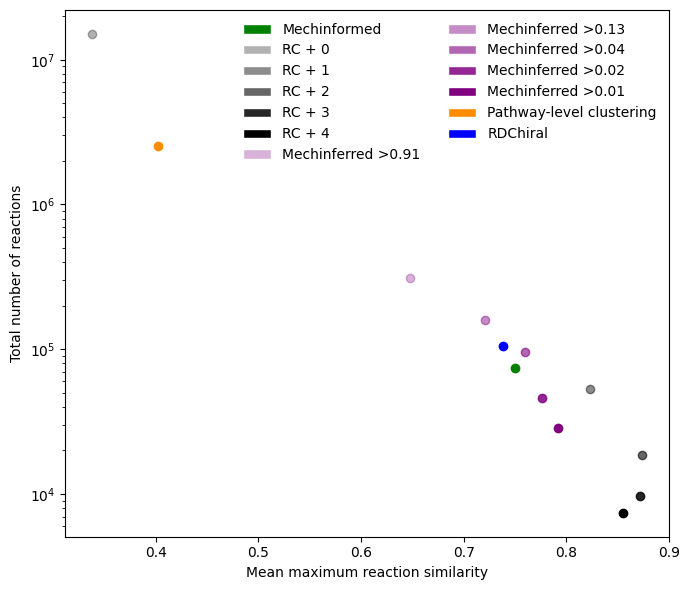

In [47]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_mean_max_rxn_sim.svg", format="svg")
plt.show()

In [48]:
rxn_df.sort_values(by="max_rxn_sim", ascending=False)

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
258907,Ra2beabb4b2278ec26c493f20b8bde5b2df3ec048bcc47...,O=C(O)CC(O)(CC(=O)O)C(=O)OC1OC(CO)C(O)C(O)C1O....,[O:1]=[C:2]([OH:3])[CH2:4][C:5]([OH:6])([CH2:7...,1,1.0,OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O.O=P(O)...,None,mechinferred_dt_91_rule_572,2_steps_250728_benchmark_starters_rules_mechin...,False
2224418,R6741acb986f29812014906bf2b1c7f858b2ff952fe282...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,1.0,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,6863583f0fa59478345ef24880df86830981998c,imt_rule_1724,2_steps_250728_benchmark_starters_rules_imt_ru...,False
2600701,R7a698e9b5c5467c1477d71f68d2c4357e8590a1b25756...,O=P(O)(O)OP(=O)(O)O.CC(=O)SCCNC(=O)CCNC(=O)C(O...,[O:1]=[P:2]([OH:3])([OH:4])[O:5][P:6](=[O:7])(...,0,1.0,O=P(O)(O)OP(=O)(O)O.CC(C)(COP(=O)(O)OP(=O)(O)O...,7584edeffca82f65bf8514e98d744d4e666ba82c,imt_rule_1695,2_steps_250728_benchmark_starters_rules_imt_ru...,False
2224418,R6741acb986f29812014906bf2b1c7f858b2ff952fe282...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,1.0,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,6863583f0fa59478345ef24880df86830981998c,imt_rule_1083,2_steps_250728_benchmark_starters_rules_imt_ru...,False
2224012,R7813c922bdd67683467d56858f13ef890beecef4f0c4e...,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,[CH3:1][S+:2]([CH2:3][CH2:4][CH:5]([NH2:6])[C:...,0,1.0,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,1334dd3bd86a018fbb2527a0b5f905f212572492,imt_rule_792,2_steps_250728_benchmark_starters_rules_imt_ru...,False
...,...,...,...,...,...,...,...,...,...,...
2735532,R10e8ffbfbf9b8f99c6bf941e6f30628678a95716056c9...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OC(CO)CO)C(OP(=O)...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,rc_plus_0_rule_658,2_steps_250728_benchmark_starters_rules_rc_plu...,False
2946060,R5c0a47a7a167a24f3ed7eabedf40c89407878fe36e501...,NC(N)=NCOCCC(N)C(=O)O>>NC(N)=NCC(N)(CCO)C(=O)O,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][O:6][CH2:7]...,0,0.0,O=P(O)(O)OCC1OC(O)C(O)C(O)C1O>>O=P(O)(O)OC1C(O...,0493458fa9ef6181439b8905507be6b4ac6bfbc1,rc_plus_0_rule_960,2_steps_250728_benchmark_starters_rules_rc_plu...,False
3179801,R726ea9a4106eeea80f54b7d78dfb895f148f76fbb9889...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)C(OP(=O)(O)O...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,rc_plus_0_rule_658,2_steps_250728_benchmark_starters_rules_rc_plu...,False
3558005,Re2a130f590c02336c1051a58054efa79ba1860531185d...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,rc_plus_0_rule_658,2_steps_250728_benchmark_starters_rules_rc_plu...,False


Venn diagrams

In [49]:
rids = {}
for exp_name, short_name in exp_labels.items():
    rids[short_name] = set(rxn_df.loc[rxn_df["expansion"] == exp_name, "id"].values)

rids.pop("RC + 0")

{'R383161800b590abd830191a261b803752bcb0cd61e2f4c7b17dbe8756cd17507',
 'Rfb13c6bdad6b5d5d773f4c2f169f3da832006ef19f0dc29477b1ea6ade83c3f9',
 'R8e6c5d5ec161b1c3ba6f1e204e815a5595e1e57788be9bef37b834674faba25b',
 'R06d092c34e9be0825536e9311b6415169bcfb70a8e5de039e1fa54b16759d3f4',
 'Rd6493d4a80de7fde29a465443db326449f880d392cd9aae8a74a1ada7f55120c',
 'Rf746e83d5767caef59bdefe173d261a9ca6a275901895ef3f2ff68c77d18a28e',
 'Rddd232e04a4b5a53e58682523f7a67a2418c98905d4e8ceaf7b8693e5f0d7488',
 'R2e82b79db6d20458d49d617e1b518d3141349bf29ca3a0dac9056920818de90f',
 'Rd285769152e83a41b907575e5bb3ebcfd426bef0f1a0beac34a855fb6fe9ce98',
 'R3fb2ad80f93c34d4b3a774048bb6a4e1dcefa66a5bc9d08a72c588da0690dbdd',
 'Rd1a39d487cabc47c6c7dc58ac641d6131102e209e2f0319994195ddc51ef59d4',
 'R476ba4b8fd6761ac67da079a0ee524d2b640c3e3f2cb80031e8ce23c8aea5319',
 'R0a61604019cfff3d66d5ac877179c7f12e529de97cfa0953e3b6260c60773a57',
 'Re4a06436b72266d663d5fd119756e7aaaaf544202ee2ebcc7043742a0c1b92b6',
 'Ra35a271177ad682a4

In [50]:
def make_venn2(left: set, right: set, left_name: str, right_name: str, left_color: tuple = (0,0,1,1), right_color: tuple = (1,0,0,1), do_save: bool = False):
    Ab = len(left - right)
    aB = len(right - left)
    AB = len(left & right)
    plt.figure()
    v = venn2(subsets = (Ab, aB, AB), set_labels = (left_name, right_name))
    v.get_patch_by_id('10').set_color(left_color)
    v.get_patch_by_id('01').set_color(right_color)

    plt.tight_layout()
    if do_save:
        plt.savefig(Path(cfg.figures) / f"{left_name.replace(' ','_')}_vs_{right_name.replace(' ','_')}_venn2.svg", format="svg")
    plt.show()

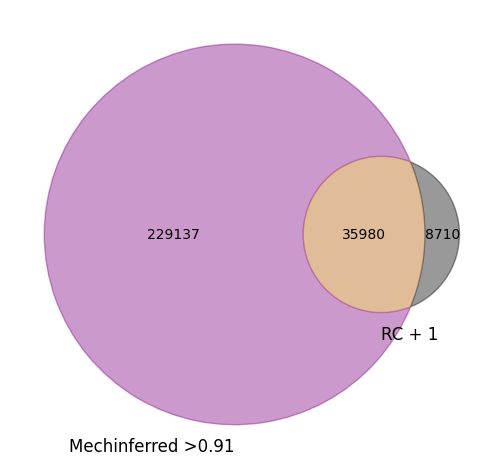

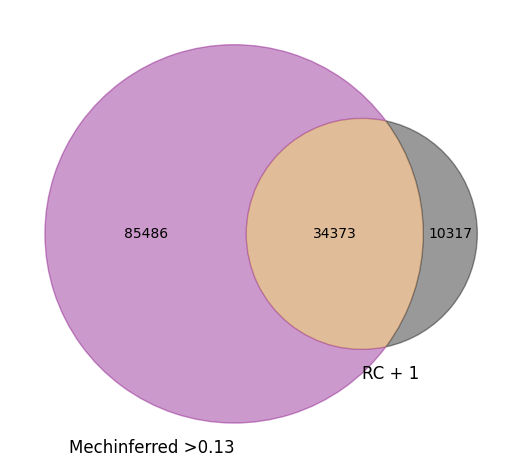

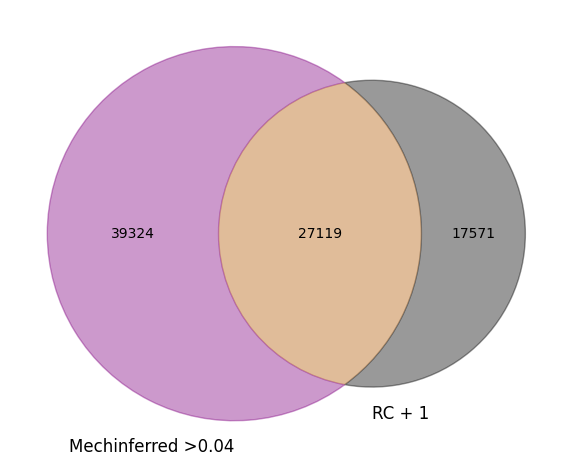

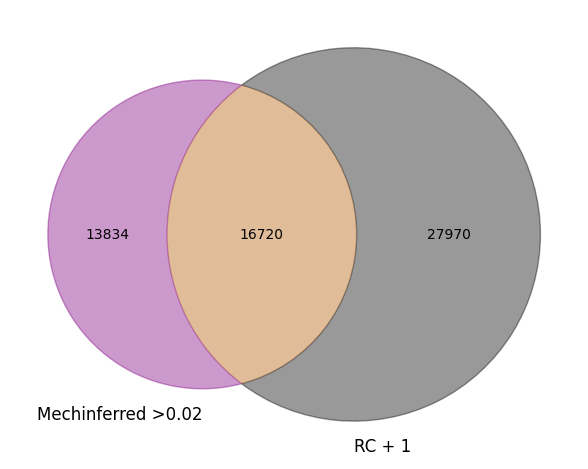

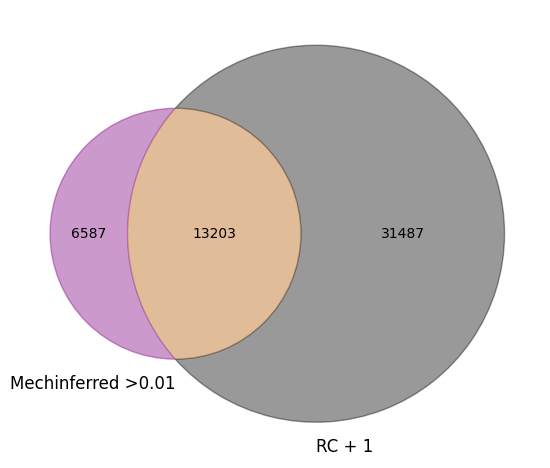

In [51]:
make_venn2(rids["Mechinferred >0.91"], rids["RC + 1"], "Mechinferred >0.91", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.13"], rids["RC + 1"], "Mechinferred >0.13", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.85), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.04"], rids["RC + 1"], "Mechinferred >0.04", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.6), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.02"], rids["RC + 1"], "Mechinferred >0.02", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.45), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.01"], rids["RC + 1"], "Mechinferred >0.01", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.3), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)

In [52]:

pk = Pickaxe()
pk.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.


FileNotFoundError: [Errno 2] No such file or directory: '/home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk'

In [ ]:
starters = set()

for cid, cpd in pk.compounds.items():
    if cpd["Type"] == "Starting Compound":
        starters.add(cpd["SMILES"])

In [ ]:
mechinfo_only_df = rxn_df.loc[
    (rxn_df["expansion"] == "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk") & (rxn_df["id"].isin(mechinfo_only))
]

mechinfo_only_df = mechinfo_only_df.sort_values(by=["dxgb_label", "max_rxn_sim"], ascending=False)
print(len(mechinfo_only_df))
mechinfo_only_df_first_gen = mechinfo_only_df.loc[mechinfo_only_df["smarts"].apply(lambda x: any([elt in starters for elt in x.split('>>')[0].split('.')]))].reset_index()
print(len(mechinfo_only_df_first_gen))
mechinfo_only_df_first_gen.head()

In [ ]:
def show_rxn_info(idx):
    row = mechinfo_only_df_first_gen.iloc[idx]
    print(row["id"])
    print("Predicted:")
    display(SVG(draw_reaction(row["smarts"])))
    print("-" * 50)
    print("Nearest analogue:")
    display(SVG(draw_reaction(row["nearest_analogue"])))

srt_idx = mechinfo_only_df_first_gen.index
interact(show_rxn_info, idx=widgets.Dropdown(options=srt_idx, value=srt_idx[0]))

In [ ]:
rc1exp = Pickaxe()
rc1exp.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk")

In [ ]:
rc1exp.reactions['Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9']